In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import tensorflow as tf
import utils

In [2]:
data_directory='/n/projects/smc/public/SMC/DLRegistration/BrainSlices/'

In [3]:
shp=[1,512,512,1]

In [4]:
raw=utils.get_raw_float_image(data_directory+'BrainSmall.raw',shp)

In [5]:
def generate_batch(batch_size, rotation_range, shifting_range):
    
    idices=np.random.choice(range(0,raw.shape[0]-4), size=batch_size)
    base=raw[idices,:,:]
    
    rotates=np.random.uniform(-rotation_range,rotation_range, size=batch_size)
    shifts=np.random.uniform(-shifting_range,shifting_range, size=[batch_size,2])
    truth=np.stack([rotates, shifts[:,0], shifts[:,1]], axis=1)
    
    dat=np.stack([sp.ndimage.rotate(sp.ndimage.shift(raw[idices[n]+3], truth[n,1:3]), truth[n,0], reshape=False ) for n in range(0,batch_size)])
    truth=np.stack([raw[idices[n]+3] for n in range(0,batch_size)])
    
    #truth[:,0]=truth[:,0]
    #truth[:,1:3]=truth[:,1:3]
    data=np.ndarray([batch_size,512,512,2])
    data[:,:,:,0]=base
    data[:,:,:,1]=dat
    
    data=data[:,128:384, 128:384,:]
    truth=np.reshape(truth[:,128:384, 128:384], [truth.shape[0],256,256,1])
    return (data, truth)

In [6]:
remake=False

training_data=0
training_truth=0
if remake:
    training_data, training_truth=generate_batch(10000,180,50)
    np.save(data_directory+'training_data', training_data)
    np.save(data_directory+'training_truth', training_truth)
else:
    training_data=np.load(data_directory+'training_data.npy')
    training_truth=np.load(data_directory+'training_truth.npy')

mean=np.mean(training_data)
std=np.std(training_data)

training_data=(training_data-mean)/std+0.5
training_truth=(training_truth-mean)/std+0.5

In [7]:
validation_data,validation_truth=generate_batch(100,180,50)
validation_data=(validation_data-mean)/std+0.5
validation_truth=(validation_truth-mean)/std+0.5

In [16]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 256,256,2])
y=tf.placeholder(dtype=tf.float32, shape=[None,256,256,1])

lr=tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')

xr=x
yr=y

base_scaler=16

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(xr, base_scaler, [5,5], padding='SAME', kernel_regularizer=regularizer))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
B2=utils.leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
C2=utils.leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
D2=utils.leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=utils.leaky_relu(tf.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
E2=utils.leaky_relu(tf.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

Flat=tf.reshape(E2, [-1, 16*16*16*base_scaler])
Dense=tf.layers.dense(Flat, 1024)
FlatDense=tf.layers.dense(Dense, 16*16*16*base_scaler)
FF0=tf.reshape(FlatDense, [-1, 16, 16, 16*base_scaler])

#Coming up
DD0=tf.layers.conv2d_transpose(FF0, 8*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
#DD1=tf.concat(axis=3, values=[DD0,D2])
DD2=utils.leaky_relu(tf.layers.conv2d(DD0, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
DD3=utils.leaky_relu(tf.layers.conv2d(DD2, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

CC0=tf.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
#CC1=tf.concat(axis=3, values=[CC0,C2])
CC2=utils.leaky_relu(tf.layers.conv2d(CC0, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
CC3=utils.leaky_relu(tf.layers.conv2d(CC2, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

BB0=tf.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
#BB1=tf.concat(axis=3, values=[BB0,B2])
BB2=utils.leaky_relu(tf.layers.conv2d(BB0, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
BB3=utils.leaky_relu(tf.layers.conv2d(BB2, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

AA0=tf.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
AA1=tf.concat(axis=3, values=[AA0,tf.reshape(x[:,:,:,1],[-1,256,256,1])])
AA2=utils.leaky_relu(tf.layers.conv2d(AA1, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
AA3=utils.leaky_relu(tf.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

logits=utils.leaky_relu(tf.layers.conv2d(AA3, 1, [1,1], padding='SAME', kernel_regularizer=regularizer))
probs=tf.tanh(logits, name='probabilities')

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
#Added this to make the outlines more potent in error function
#OutError, MaskError=tf.split(LSQ, [1,1], 3)
#loss=1*tf.reduce_mean(OutError)+0.1*tf.reduce_mean(MaskError)
loss=tf.reduce_mean(LSQ, name='error')
l2_loss = tf.losses.get_regularization_loss()
#loss=loss+l2_loss/1000

train_op=tf.train.AdamOptimizer(learning_rate=lr, name='trainer').minimize(loss)

[0, 1.4659739, 1.3301208]


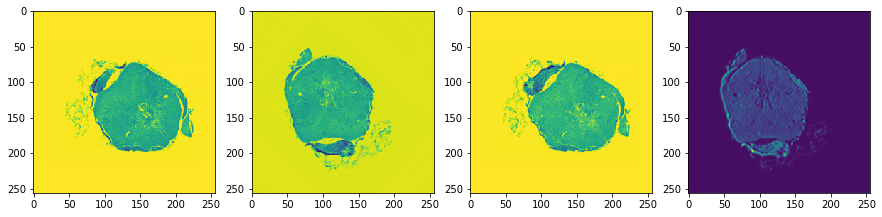

[100, 0.24688026, 0.28052723]


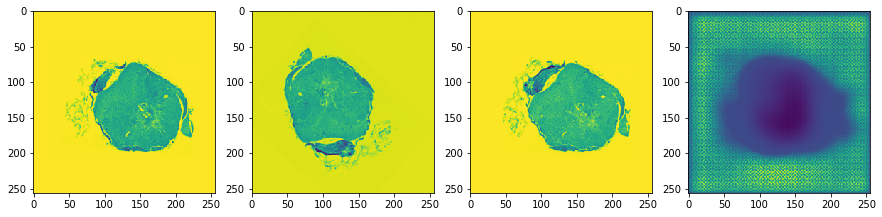

[200, 0.21460077, 0.23695168]


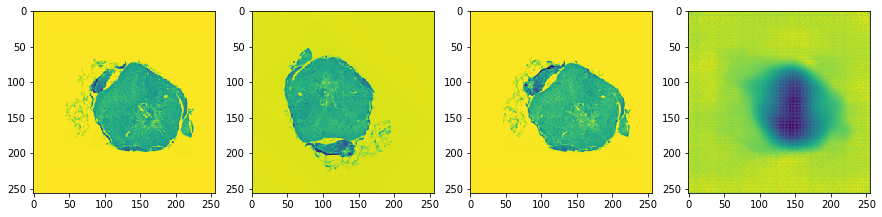

[300, 0.32895535, 0.22539037]


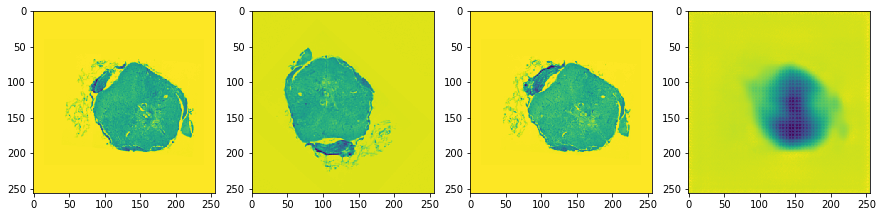

[400, 0.2316287, 0.21983108]


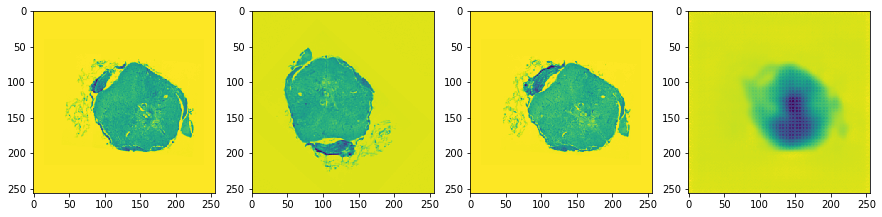

[500, 0.23155817, 0.21438682]


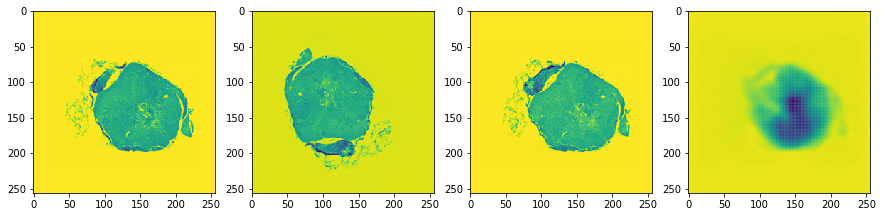

[600, 0.25678134, 0.2114808]


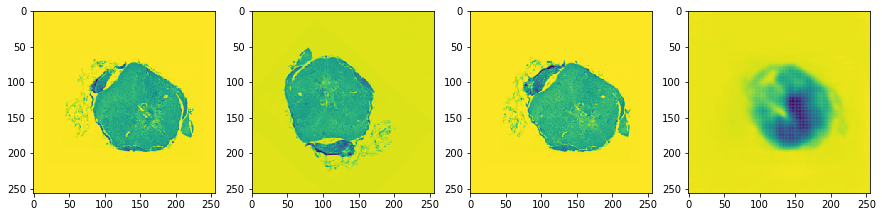

[700, 0.13717026, 0.20461054]


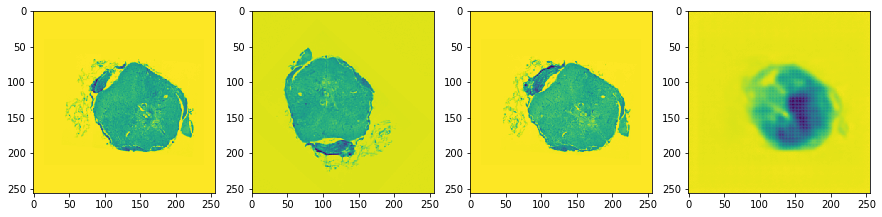

[800, 0.18081674, 0.19985412]


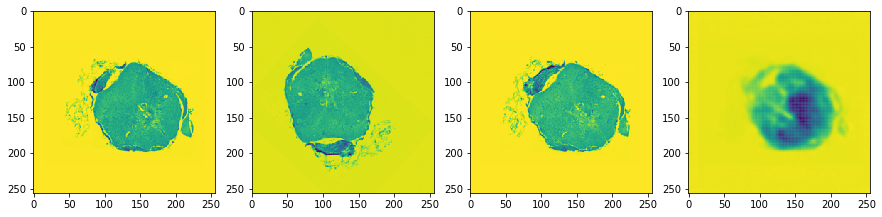

[900, 0.15638436, 0.19731483]


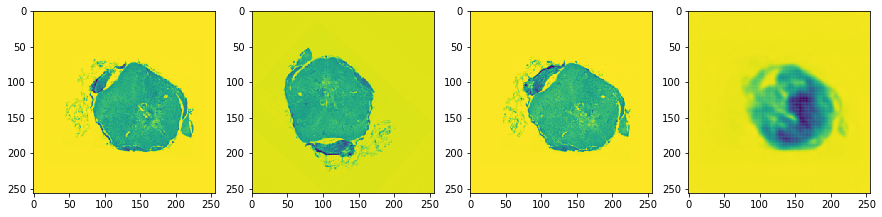

[1000, 0.13639715, 0.19437626]


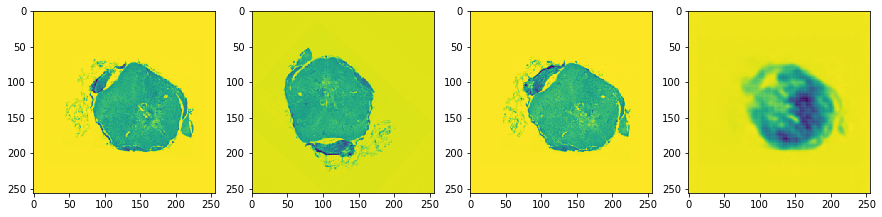

[1100, 0.22709465, 0.19320613]


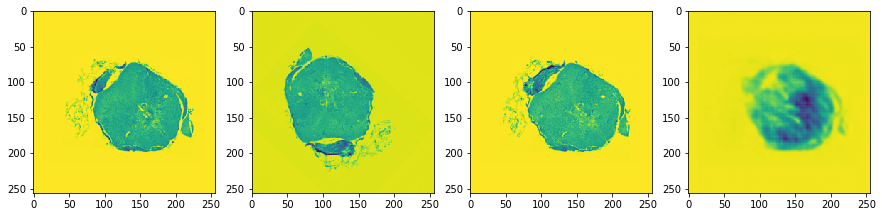

[1200, 0.19493976, 0.19070838]


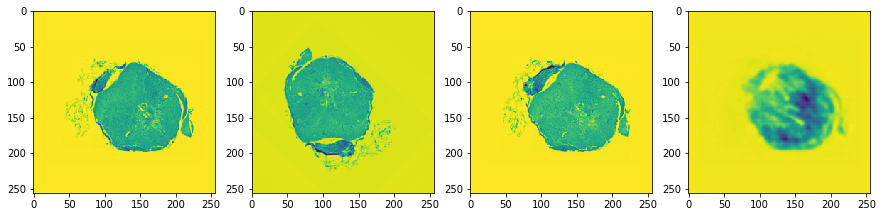

[1300, 0.13663825, 0.18778302]


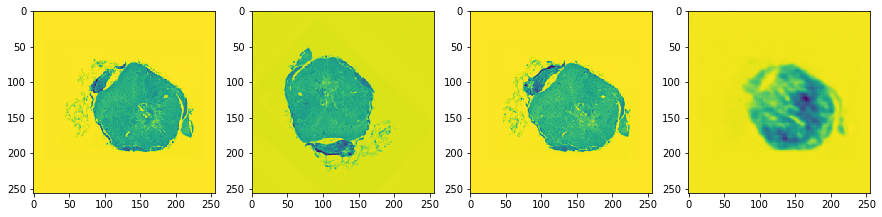

[1400, 0.21424142, 0.18824941]


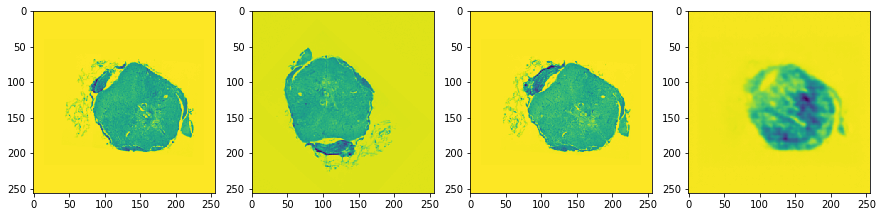

[1500, 0.17613907, 0.1862145]


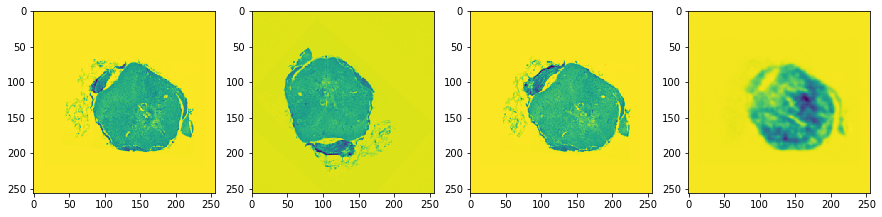

[1600, 0.19228525, 0.18438858]


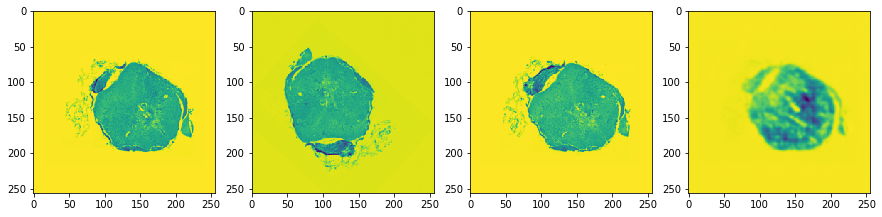

[1700, 0.1546821, 0.18474819]


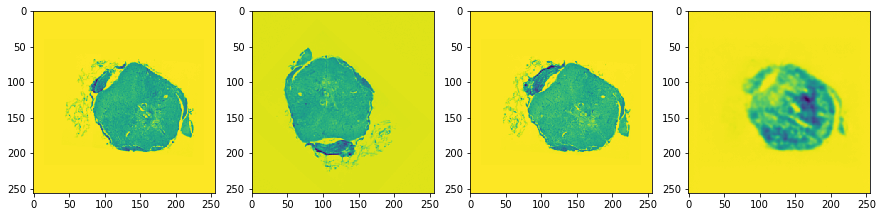

[1800, 0.17001787, 0.18310356]


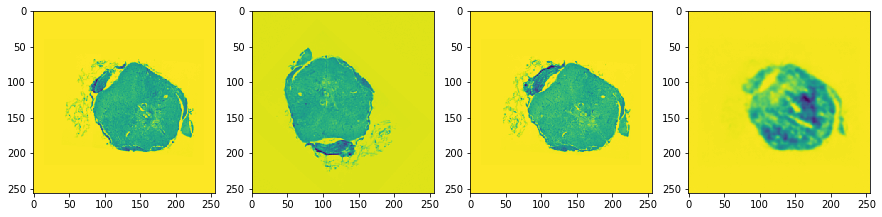

[1900, 0.20493293, 0.18203843]


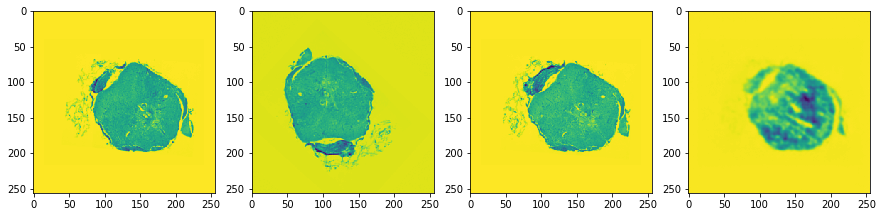

[2000, 0.20821035, 0.18055002]


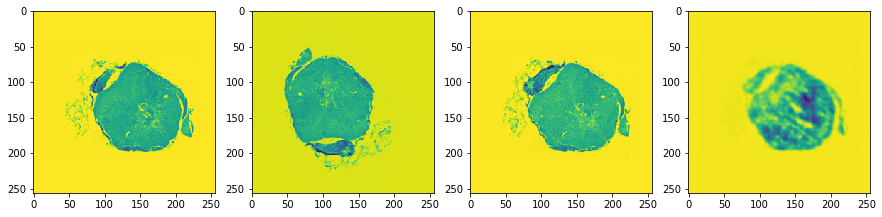

[2100, 0.20999059, 0.18021603]


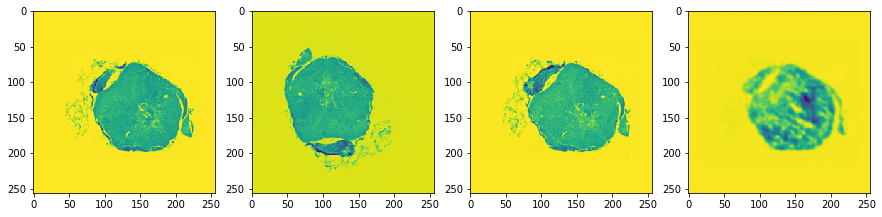

[2200, 0.16127327, 0.17905769]


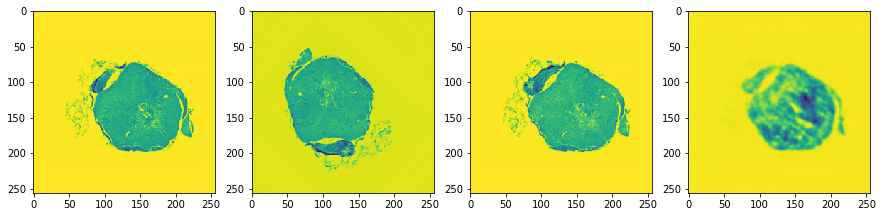

[2300, 0.1421853, 0.17890528]


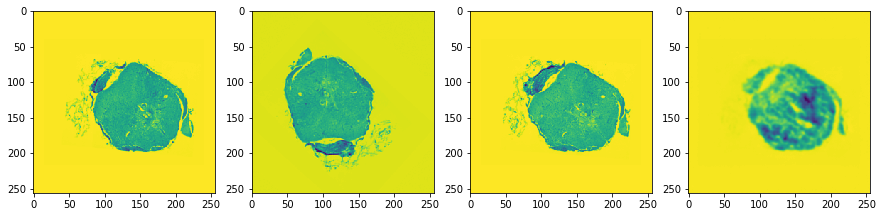

[2400, 0.19366392, 0.1776751]


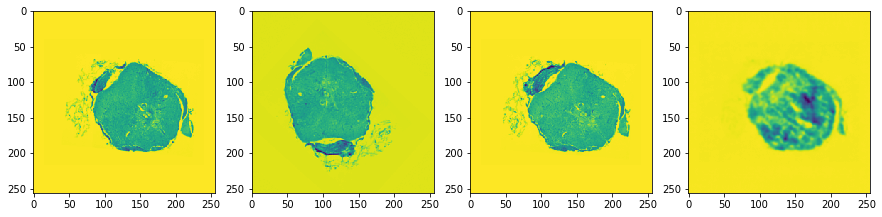

[2500, 0.19743894, 0.18157433]


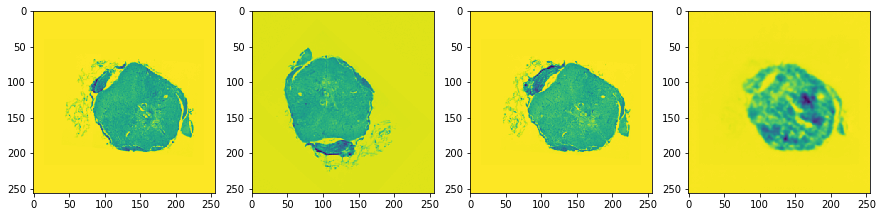

[2600, 0.21958637, 0.17688164]


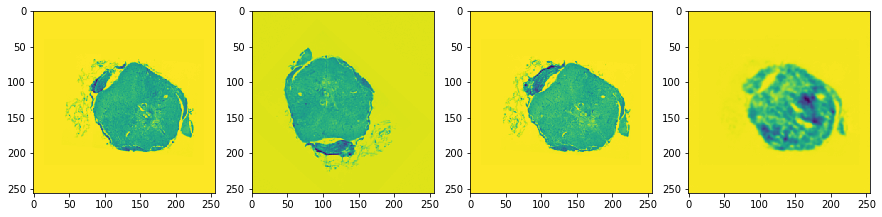

[2700, 0.19533896, 0.17657027]


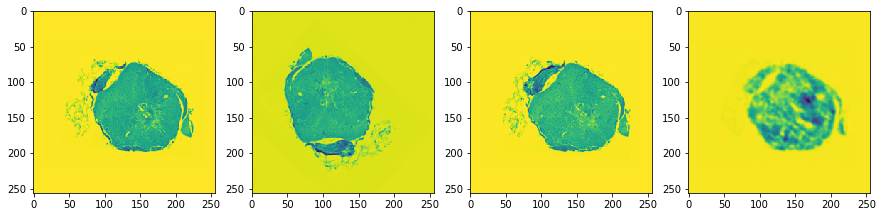

[2800, 0.218859, 0.17453516]


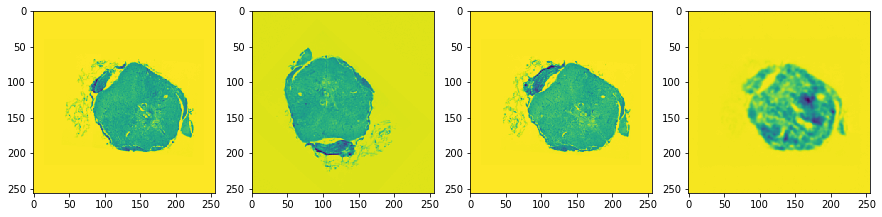

[2900, 0.14749703, 0.17414778]


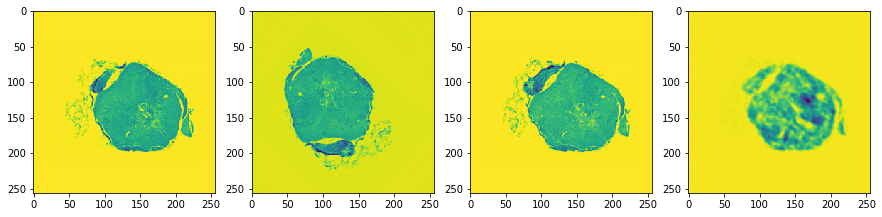

[3000, 0.19996478, 0.17467506]


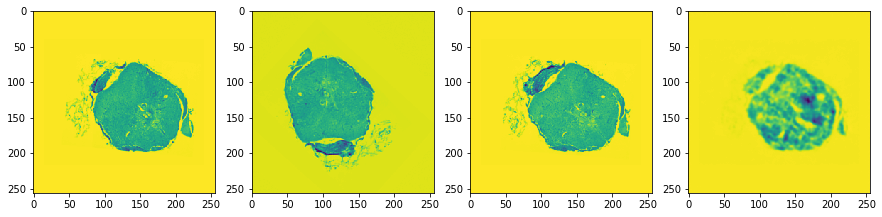

[3100, 0.1911602, 0.1737758]


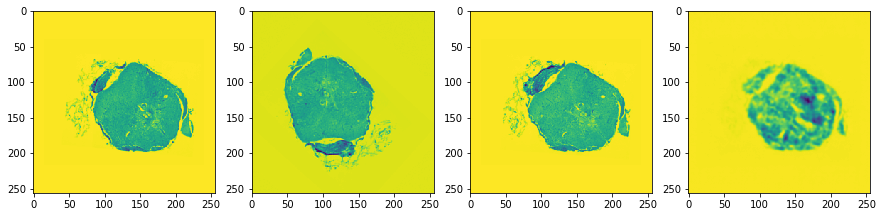

[3200, 0.18671378, 0.17327787]


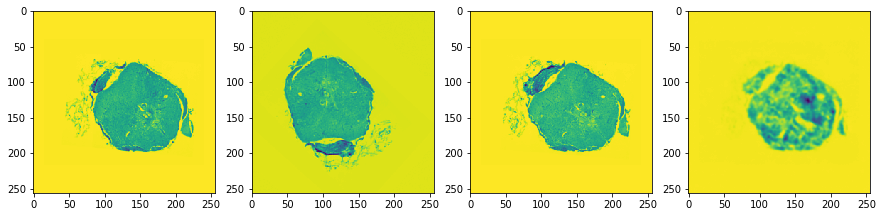

[3300, 0.15171444, 0.17286891]


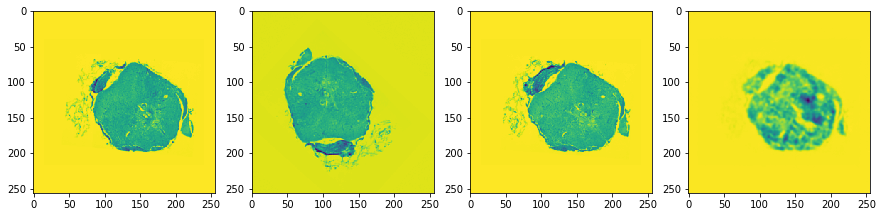

[3400, 0.1318354, 0.17446232]


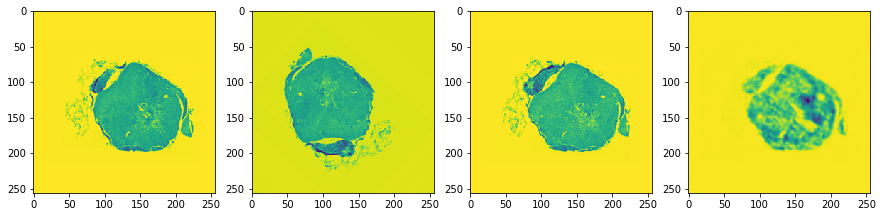

[3500, 0.11193824, 0.17209807]


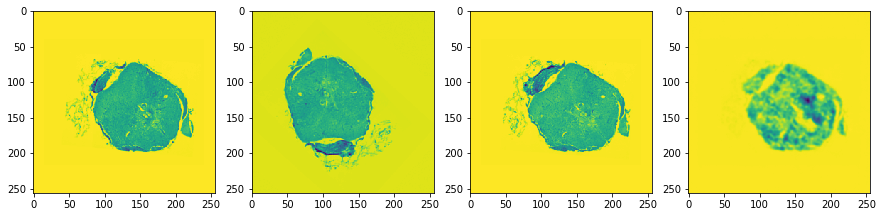

[3600, 0.1443857, 0.1715985]


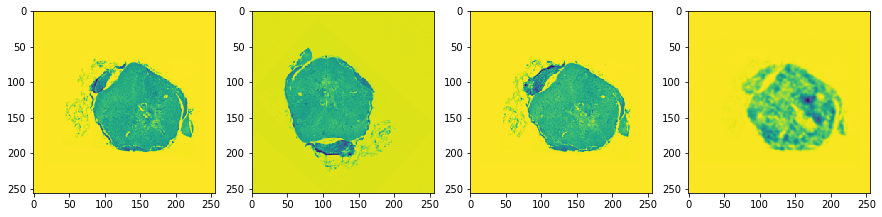

[3700, 0.12664364, 0.17170833]


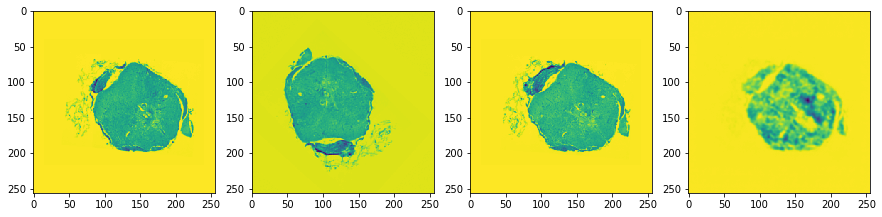

[3800, 0.19328925, 0.17250499]


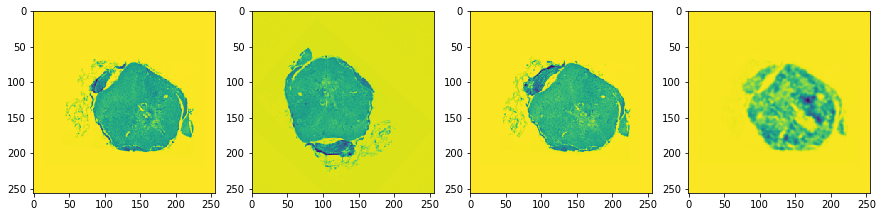

[3900, 0.18843406, 0.17101227]


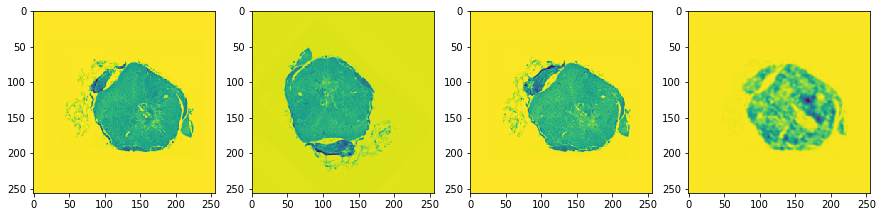

[4000, 0.16269553, 0.17021519]


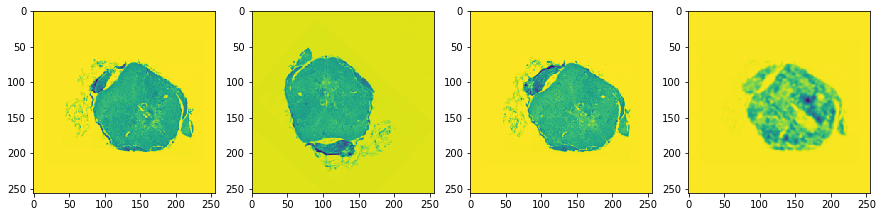

[4100, 0.25212008, 0.17017932]


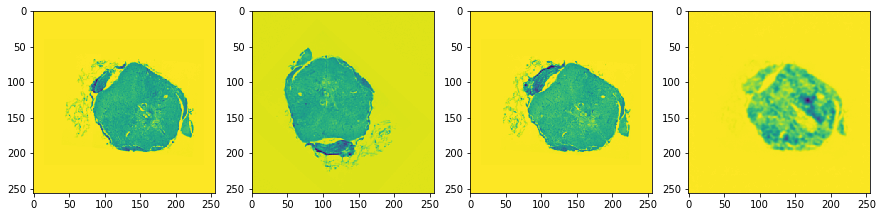

[4200, 0.12669496, 0.17092144]


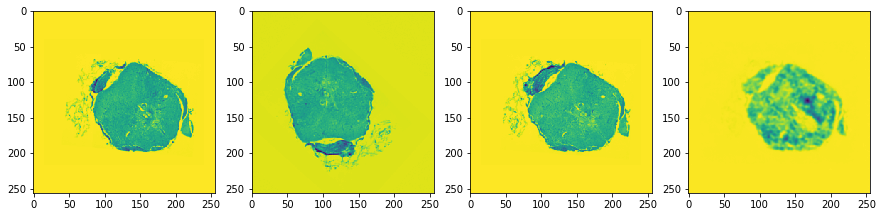

[4300, 0.20094793, 0.17219006]


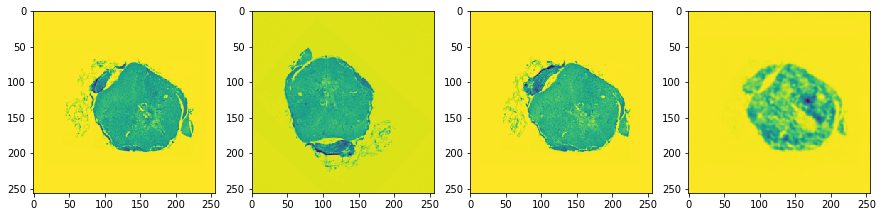

[4400, 0.2190123, 0.16974089]


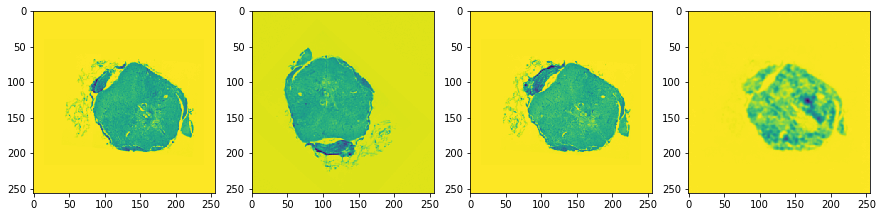

[4500, 0.17031367, 0.16971886]


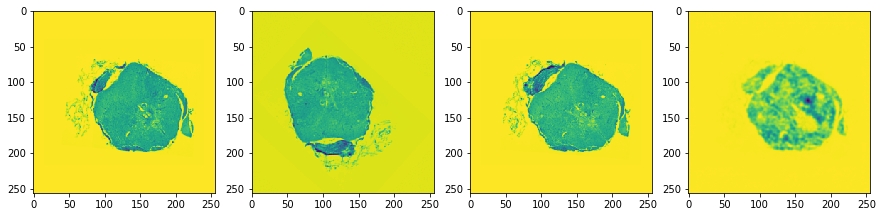

[4600, 0.17587425, 0.16842441]


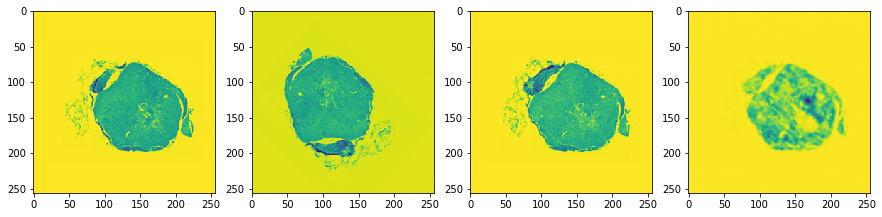

[4700, 0.16201076, 0.16979508]


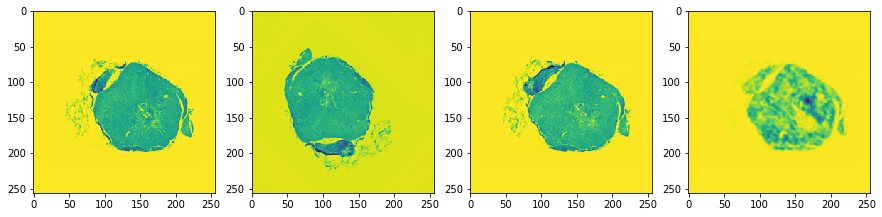

[4800, 0.2373318, 0.1683028]


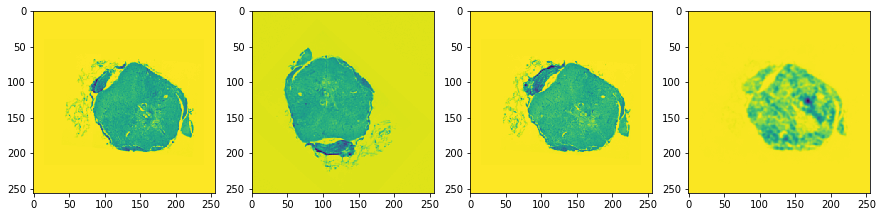

[4900, 0.16377464, 0.16780743]


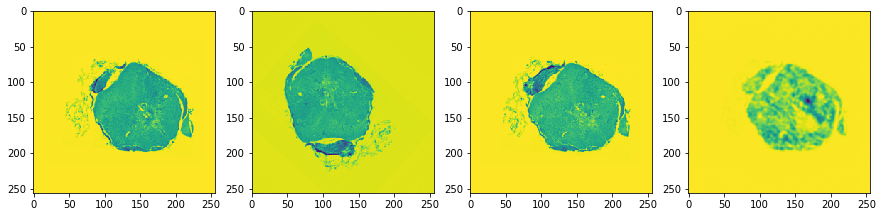

In [17]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=50)
for f in range(0,5000):
    idx=np.random.choice(training_data.shape[0], replace=False, size=[40])
    cur_train=training_data[idx,:,:,:]
    cur_truth=training_truth[idx,:,:,:]
    _,results, losses=sess.run([train_op, logits, loss], feed_dict={x:cur_train, y:cur_truth, lr:0.001})
    if (f%100==0):
        res, valid_loss=sess.run([logits,loss], feed_dict={x:validation_data, y:validation_truth})
        print([f,losses, valid_loss])
        utils.plot_4x1(validation_data[0,:,:,0], validation_data[0,:,:,1], validation_truth[0,:,:,0], res[0,:,:,0])
        plt.show()
        #saver.save(sess, data_directory+'NewModels/Model'+str(f))
    

In [18]:
res, valid_loss=sess.run([logits,loss], feed_dict={x:validation_data, y:validation_truth})

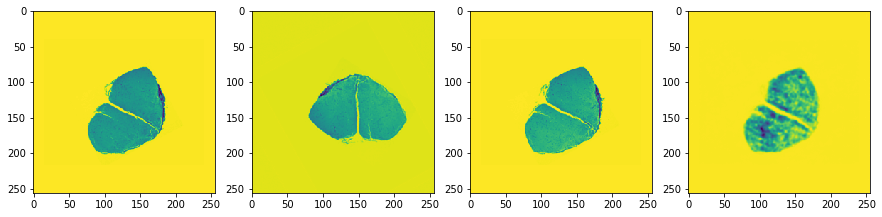

In [28]:
idx=np.random.randint(0,100)
utils.plot_4x1(validation_data[idx,:,:,0], validation_data[idx,:,:,1], validation_truth[idx,:,:,0], res[idx,:,:,0])

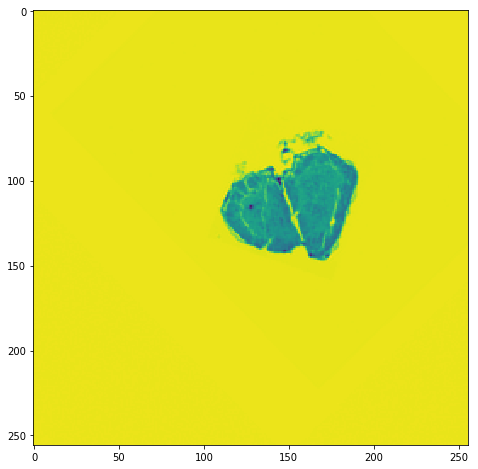

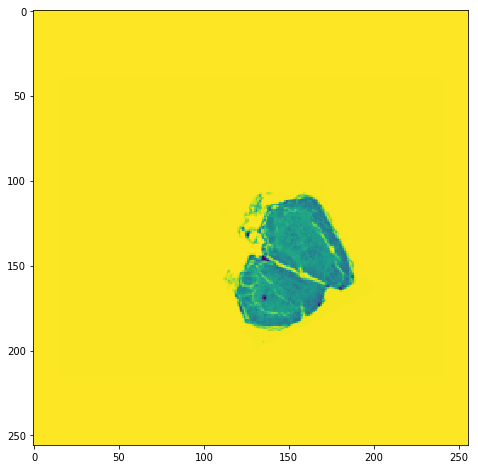

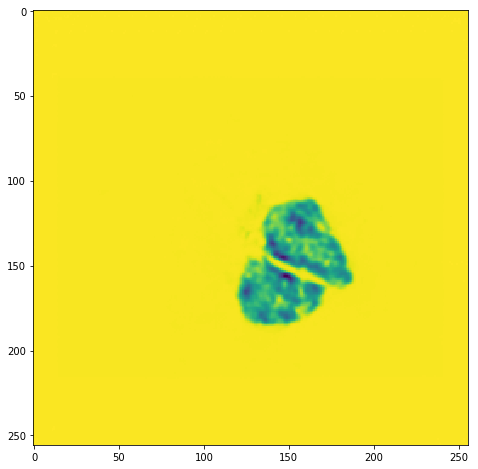

In [20]:
idx=np.random.randint(0,100)
plt.figure(figsize=[8,8])
plt.imshow(validation_data[idx,:,:,1])
plt.figure(figsize=[8,8])
plt.imshow(validation_truth[idx,:,:,0])
plt.figure(figsize=[8,8])
plt.imshow(res[idx,:,:,0])

In [52]:
idx=np.random.randint(0,100)
print(idx)
print(res[idx,:])
print(validation_truth[idx,:])

26
[-104.790146   42.04472    42.314995]
[-127.96739047   46.01618485   48.00432569]
